MNIST loaded — Train 60000 | Test 10000
GPU initialized: True
Epoch 0, Loss: 0.9664
Epoch 1, Loss: 0.3067
Epoch 2, Loss: 0.1988
Epoch 0, Loss: 0.1013
Epoch 1, Loss: 0.0607
Training took 35.74sEpoch 2, Loss: 0.0451


🔬 INITIAL MODEL EVALUATION (Test Set)

📊 Running Test Set

📈 ADHD Performance Analysis
----------------------------------------------------------------------
  0-10%     |   3772 samples (94.30%)
  10-20%    |     21 samples ( 0.53%)
  20-30%    |     11 samples ( 0.28%)
  30-40%    |     27 samples ( 0.68%)
  40-50%    |     17 samples ( 0.42%)
  50-100%   |     94 samples ( 2.35%)
  100%+     |     58 samples ( 1.45%)

  Total     |   4000 samples
  ADHD Score |  96.13%
  Accuracy  |  94.30%

🎯 Confidence Analysis
----------------------------------------------------------------------
  Confidence   | Count    | Percent  | Accuracy
  ------------ | -------- | -------- | --------
  00-10%       |      0   |   0.00%  |  0.00%
  10-20%       |    217   |   5.42%  | 56.68%
  2

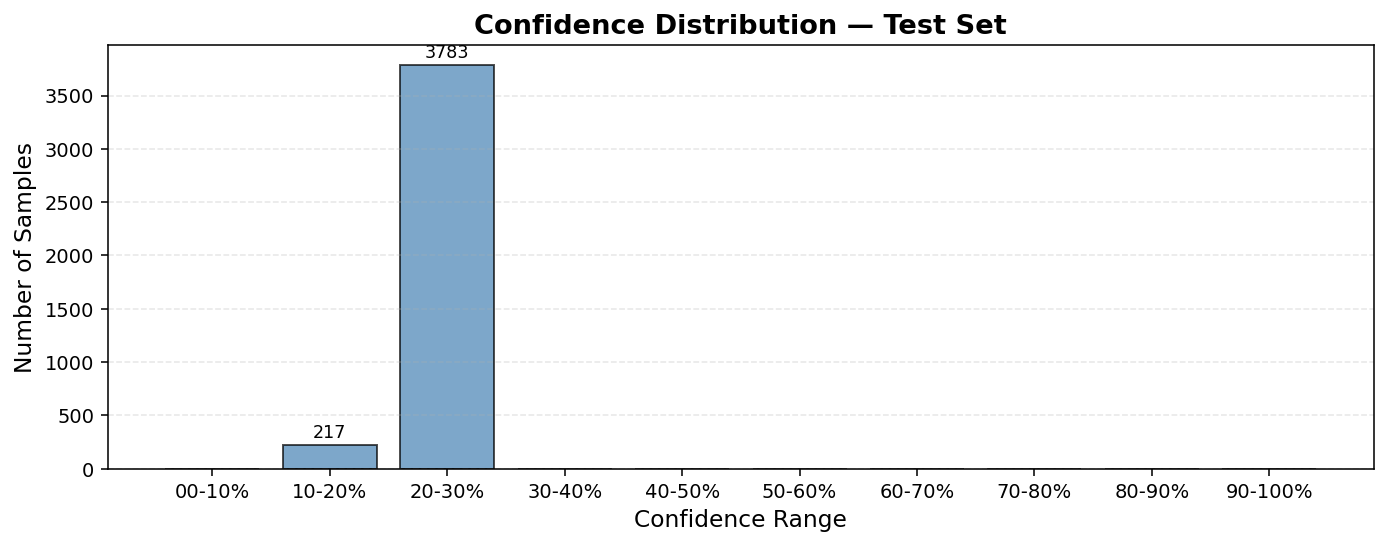

📊 Saved: reliability_test_set.png


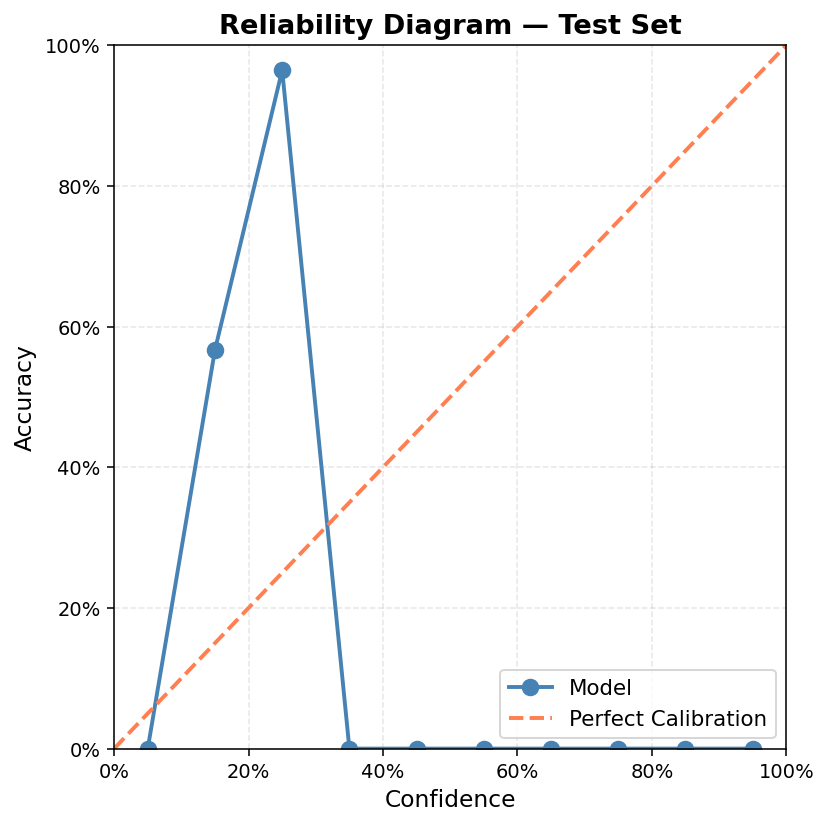

📊 Saved: confusion_matrix_test_set.png


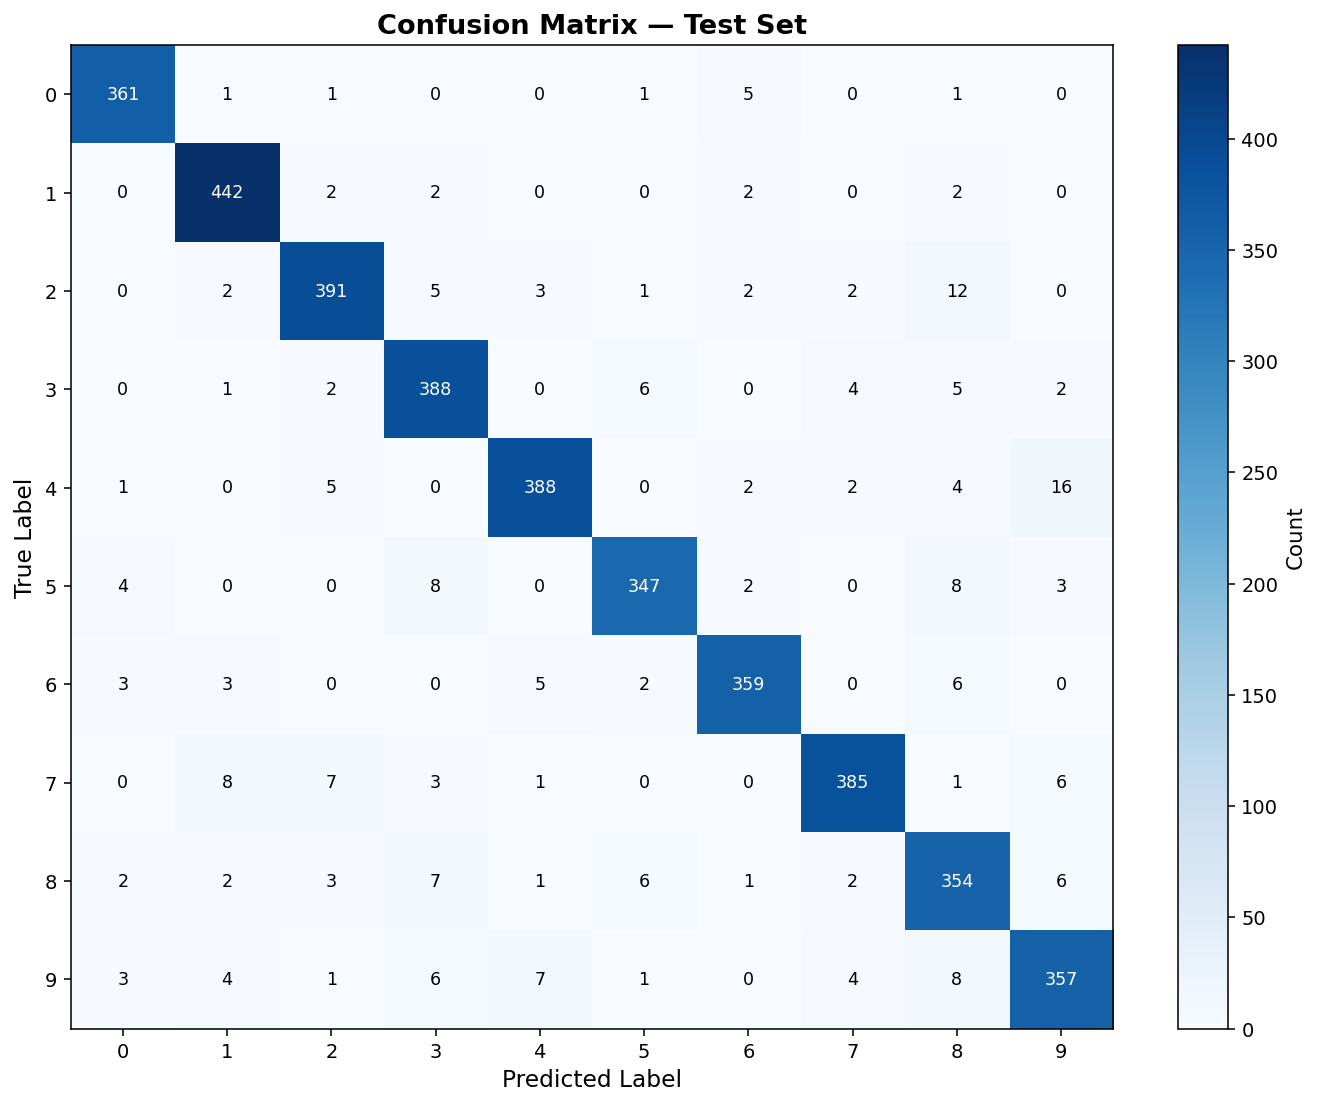

💾 Saved model → mnist_paragon_model.json

🔁 RELOADING MODEL FROM CHECKPOINT
📥 Loaded model from mnist_paragon_model.json
GPU initialized (reloaded): True

🔬 RELOADED MODEL EVALUATION (Test Set)

📊 Running Test Set (Reloaded)

📈 ADHD Performance Analysis
----------------------------------------------------------------------
  0-10%     |   3772 samples (94.30%)
  10-20%    |     21 samples ( 0.53%)
  20-30%    |     11 samples ( 0.28%)
  30-40%    |     27 samples ( 0.68%)
  40-50%    |     17 samples ( 0.42%)
  50-100%   |     94 samples ( 2.35%)
  100%+     |     58 samples ( 1.45%)

  Total     |   4000 samples
  ADHD Score |  96.13%
  Accuracy  |  94.30%

🎯 Confidence Analysis
----------------------------------------------------------------------
  Confidence   | Count    | Percent  | Accuracy
  ------------ | -------- | -------- | --------
  00-10%       |      0   |   0.00%  |  0.00%
  10-20%       |    217   |   5.42%  | 56.68%
  20-30%       |   3783   |  94.58%  | 96.46%
  30-4

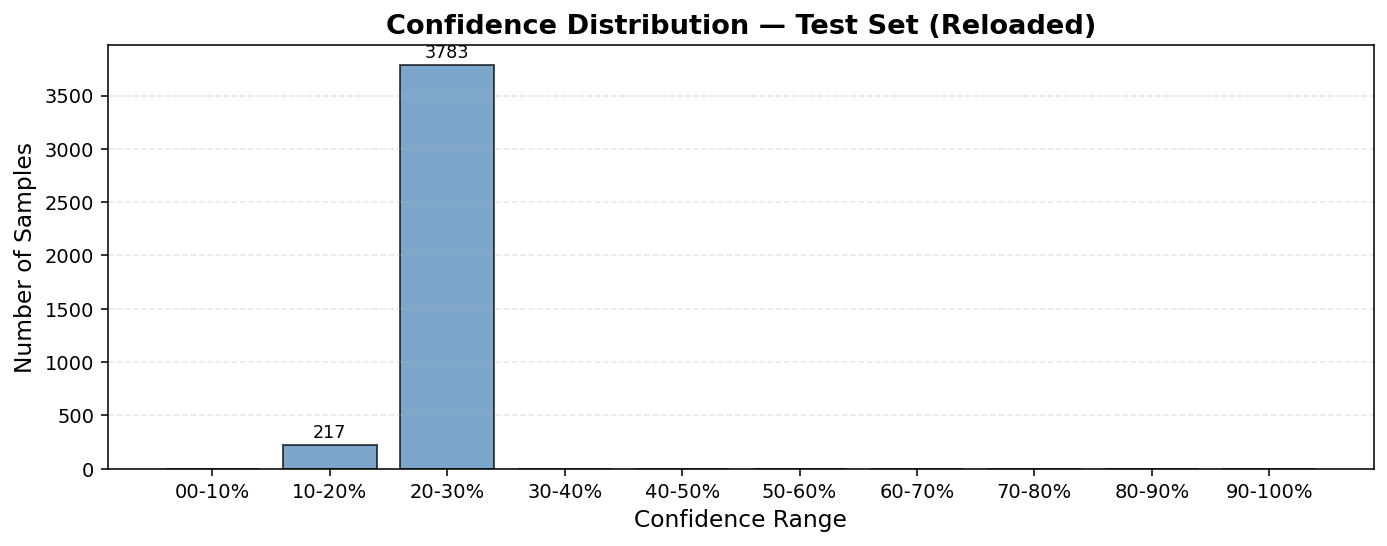

📊 Saved: reliability_test_set_(reloaded).png


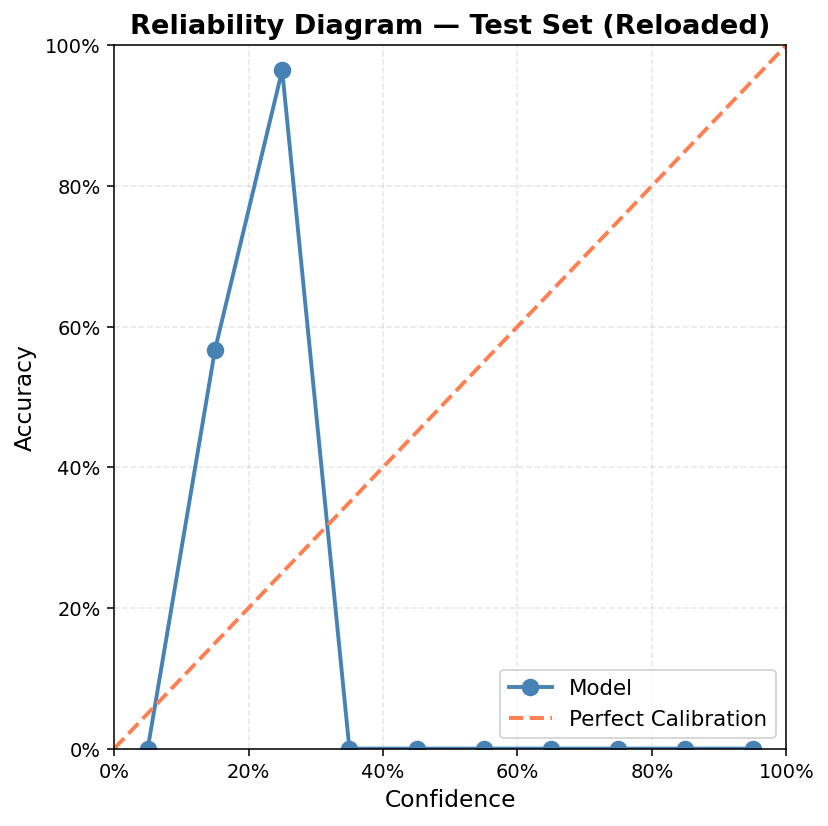

📊 Saved: confusion_matrix_test_set_(reloaded).png


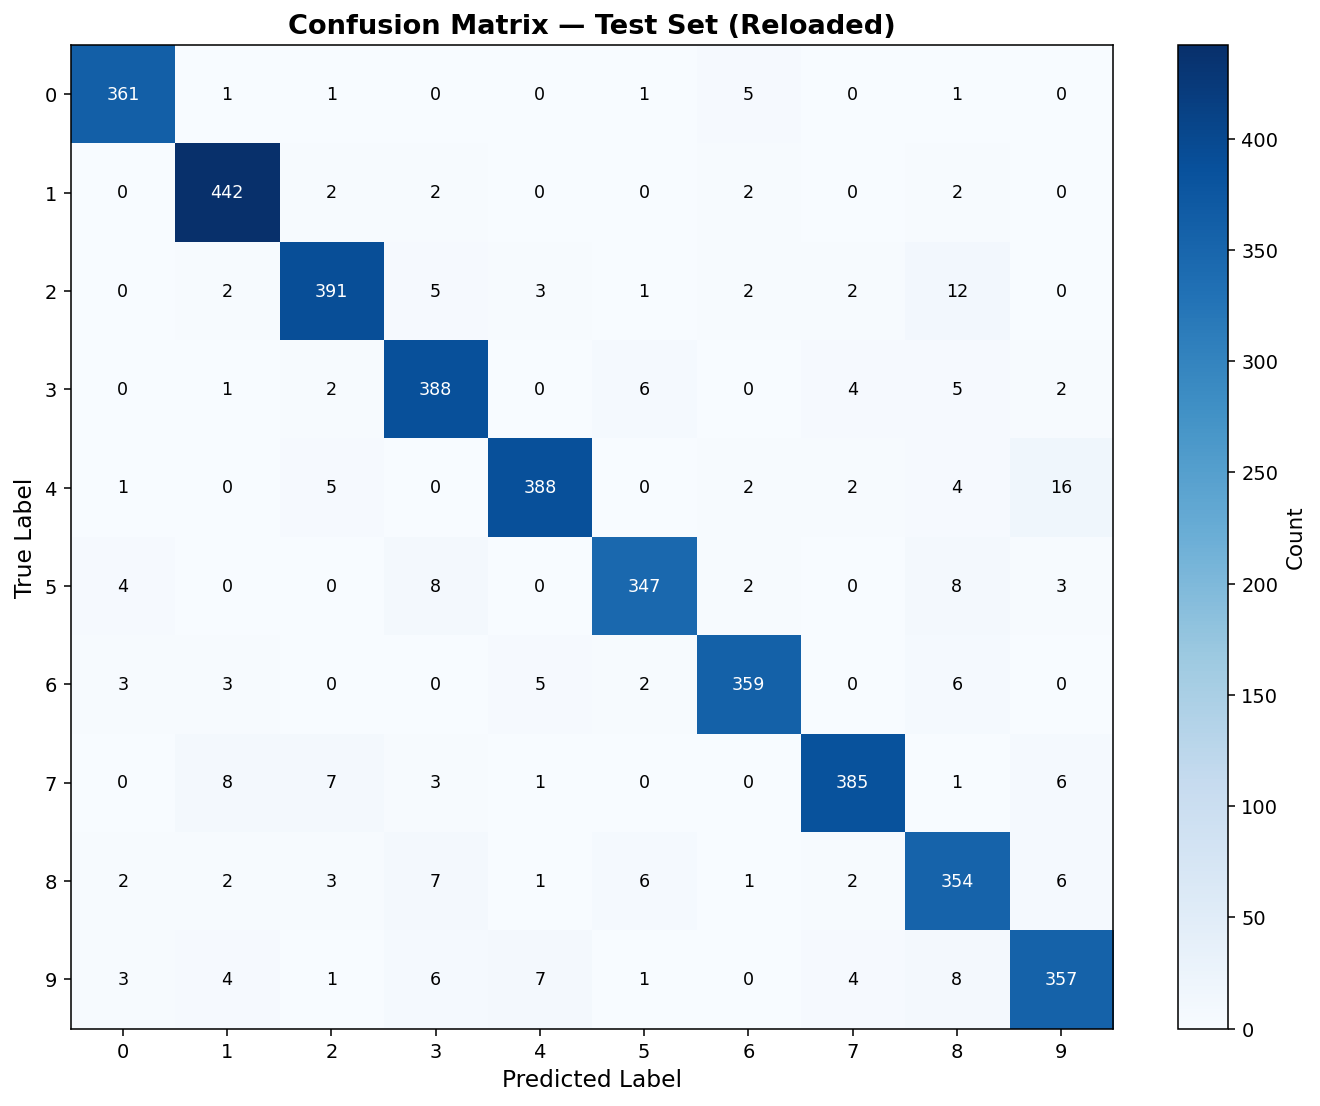


✅ VERIFICATION: Original vs Reloaded Metrics

  Metric                    | Original     | Reloaded     | Match
  ------------------------- | ------------ | ------------ | -----
  ADHD Score                |       96.13% |       96.13% | ✓
  Accuracy                  |       94.30% |       94.30% | ✓
  Calibration Error (ECE)   |       0.6984 |       0.6984 | ✓

  ✅ All metrics match! Checkpoint save/load is working correctly.

✨ Analysis complete. All visualizations saved.


In [21]:
# Paragon-Py — MNIST Analysis with Properly Aligned Metrics
# This version ensures all metrics, graphs, and evaluations are synchronized

import os, gzip, struct, urllib.request, random, time, json, math
from collections import defaultdict

import paragon_py as p
from paragon_py import utils as U

# ── Plot Configuration ────────────────────────────────────────────────────────
PLOT = True
try:
    import matplotlib.pyplot as plt
    from matplotlib.ticker import PercentFormatter
    import numpy as np
    IN_NOTEBOOK = False
    try:
        from IPython import get_ipython
        IN_NOTEBOOK = get_ipython() is not None
    except Exception:
        IN_NOTEBOOK = False
except Exception:
    PLOT = False
    IN_NOTEBOOK = False
    plt = None
    np = None

def render_or_save(fig, filename: str):
    """Show inline if in notebook; always save PNG."""
    if not PLOT:
        return
    fig.savefig(filename, dpi=140, bbox_inches="tight")
    print(f"📊 Saved: {filename}")
    if IN_NOTEBOOK:
        try:
            import IPython.display as disp
            disp.display(disp.Image(filename))
        except Exception:
            pass
    plt.close(fig)

# ── Environment ───────────────────────────────────────────────────────────────
use_gpu = True
os.environ.setdefault("DISPLAY", ":0")
os.environ.setdefault("WGPU_BACKEND", "gl")
os.environ.setdefault("WGPU_BACKENDS", "gl")
os.environ.setdefault("EGL_PLATFORM", "x11")
random.seed(1337)

# ── MNIST Data Loader ─────────────────────────────────────────────────────────
DATA_DIR = "./mnist_idx"
URLS = {
    "train_images": "https://storage.googleapis.com/cvdf-datasets/mnist/train-images-idx3-ubyte.gz",
    "train_labels": "https://storage.googleapis.com/cvdf-datasets/mnist/train-labels-idx1-ubyte.gz",
    "test_images":  "https://storage.googleapis.com/cvdf-datasets/mnist/t10k-images-idx3-ubyte.gz",
    "test_labels":  "https://storage.googleapis.com/cvdf-datasets/mnist/t10k-labels-idx1-ubyte.gz",
}
os.makedirs(DATA_DIR, exist_ok=True)

def download_file(url, out_path):
    if not os.path.exists(out_path):
        print(f"→ Downloading {url}")
        urllib.request.urlretrieve(url, out_path)

paths = {}
for k, url in URLS.items():
    paths[k] = os.path.join(DATA_DIR, os.path.basename(url))
    download_file(url, paths[k])

def read_images_2d(gz_path):
    with gzip.open(gz_path, "rb") as f:
        magic, num, rows, cols = struct.unpack(">IIII", f.read(16))
        assert magic == 2051, f"Bad magic: {magic}"
        buf = f.read(rows * cols * num)
    images = []
    for i in range(num):
        offs = i * rows * cols
        img = [[buf[offs + r*cols + c] / 255.0 for c in range(cols)] for r in range(rows)]
        images.append(img)
    return images

def read_labels_1x10(gz_path):
    with gzip.open(gz_path, "rb") as f:
        magic, num = struct.unpack(">II", f.read(8))
        assert magic == 2049, f"Bad magic: {magic}"
        labs = f.read(num)
    out = []
    for b in labs:
        one = [0.0]*10
        one[b] = 1.0
        out.append([one])
    return out

def read_label_indices(gz_path):
    """Read labels as integer indices (0-9)"""
    with gzip.open(gz_path, "rb") as f:
        magic, num = struct.unpack(">II", f.read(8))
        assert magic == 2049, f"Bad magic: {magic}"
        labs = f.read(num)
    return [int(b) for b in labs]

train_images = read_images_2d(paths["train_images"])
train_labels = read_labels_1x10(paths["train_labels"])
train_label_indices = read_label_indices(paths["train_labels"])

test_images  = read_images_2d(paths["test_images"])
test_labels  = read_labels_1x10(paths["test_labels"])
test_label_indices = read_label_indices(paths["test_labels"])

print(f"MNIST loaded — Train {len(train_images)} | Test {len(test_images)}")

# Subset for faster training
N_TRAIN, N_TEST = 20000, 4000
X_train, Y_train, Y_train_idx = train_images[:N_TRAIN], train_labels[:N_TRAIN], train_label_indices[:N_TRAIN]
X_test,  Y_test,  Y_test_idx  = test_images[:N_TEST],   test_labels[:N_TEST],   test_label_indices[:N_TEST]

# ── Model Definition ──────────────────────────────────────────────────────────
SHAPES    = [(28,28), (256,1), (10,1)]
ACTIVS    = ["linear","relu","softmax"]
TRAINABLE = [True, True, True]
OUT_WIDTH = 10

def build_network() -> int:
    h = p.new_network(shapes=SHAPES, activations=ACTIVS, trainable=TRAINABLE, use_gpu=use_gpu)
    if use_gpu:
        try:
            print("GPU initialized:", p.initialize_gpu(h))
        except Exception as e:
            print("GPU init failed (non-fatal):", e)
    return h

h = build_network()

# ── Training Configuration ────────────────────────────────────────────────────
E1, LR1 = 3, 0.05
E2, LR2 = 3, 0.02
CLIP_MAX, CLIP_MIN = 2.0, -2.0
DO_TRAIN = True  # Set to False to skip training

if DO_TRAIN:
    t0 = time.time()
    p.train(h, X_train, Y_train, epochs=E1, lr=LR1, shuffle=True, clip_max=CLIP_MAX, clip_min=CLIP_MIN)
    p.train(h, X_train, Y_train, epochs=E2, lr=LR2, shuffle=True, clip_max=CLIP_MAX, clip_min=CLIP_MIN)
    print(f"Training took {time.time()-t0:.2f}s")
else:
    print("Skipping training (DO_TRAIN=False)")

# ── Core Inference Functions ──────────────────────────────────────────────────
def softmax(logits):
    m = max(logits)
    exps = [math.exp(x - m) for x in logits]
    s = sum(exps) or 1.0
    return [e/s for e in exps]

def head_logits(full_out):
    if len(full_out) < OUT_WIDTH:
        raise RuntimeError(f"ExtractOutput too short ({len(full_out)}) for head width {OUT_WIDTH}")
    return full_out[-OUT_WIDTH:]

def predict_probs(img_28x28):
    p.forward(h, img_28x28)
    out = p.extract_output(h)
    return softmax(head_logits(out))

def argmax(vec):
    return max(range(len(vec)), key=lambda i: vec[i])

# ── Comprehensive Evaluation Suite ───────────────────────────────────────────
class ModelEvaluator:
    """Unified evaluation system ensuring all metrics are aligned"""
    
    def __init__(self, name="Evaluation"):
        self.name = name
        self.predictions = []  # Store all predictions for analysis
        self.true_labels = []
        self.confidences = []
        self.correct = []
        
    def evaluate_dataset(self, X, Y_idx):
        """Evaluate entire dataset and store results"""
        print(f"\n{'='*70}")
        print(f"📊 Running {self.name}")
        print(f"{'='*70}")
        
        self.predictions = []
        self.true_labels = []
        self.confidences = []
        self.correct = []
        
        for i, (img, true_label) in enumerate(zip(X, Y_idx)):
            probs = predict_probs(img)
            pred_label = argmax(probs)
            confidence = max(probs)
            is_correct = (pred_label == true_label)
            
            self.predictions.append(pred_label)
            self.true_labels.append(true_label)
            self.confidences.append(confidence)
            self.correct.append(is_correct)
        
        # Compute all metrics from the same data
        self.compute_adhd_metrics()
        self.compute_confidence_metrics()
        self.compute_confusion_matrix()
        
    def compute_adhd_metrics(self):
        """ADHD deviation metrics"""
        print(f"\n📈 ADHD Performance Analysis")
        print("-" * 70)
        
        buckets = {
            "0-10%": 0, "10-20%": 0, "20-30%": 0, "30-40%": 0,
            "40-50%": 0, "50-100%": 0, "100%+": 0
        }
        
        score_sum = 0.0
        
        for true_label, pred_label in zip(self.true_labels, self.predictions):
            # ADHD deviation calculation (matching adhd.go)
            expected = float(true_label)
            actual = float(pred_label)
            
            if abs(expected) < 1e-10:
                dev = abs(actual - expected) * 100.0
            else:
                dev = abs((actual - expected) / expected * 100.0)
            
            # Bucket assignment
            if dev <= 10:      bucket = "0-10%"
            elif dev <= 20:    bucket = "10-20%"
            elif dev <= 30:    bucket = "20-30%"
            elif dev <= 40:    bucket = "30-40%"
            elif dev <= 50:    bucket = "40-50%"
            elif dev <= 100:   bucket = "50-100%"
            else:              bucket = "100%+"
            
            buckets[bucket] += 1
            score_sum += max(0.0, 100.0 - dev)
        
        total = len(self.true_labels)
        score = score_sum / total if total > 0 else 0.0
        accuracy = sum(self.correct) / total * 100 if total > 0 else 0.0
        
        # Display results
        for name in ["0-10%", "10-20%", "20-30%", "30-40%", "40-50%", "50-100%", "100%+"]:
            cnt = buckets[name]
            pct = 100.0 * cnt / total if total > 0 else 0.0
            print(f"  {name:<9} | {cnt:6d} samples ({pct:5.2f}%)")
        
        print(f"\n  {'Total':<9} | {total:6d} samples")
        print(f"  {'ADHD Score':<9} | {score:6.2f}%")
        print(f"  {'Accuracy':<9} | {accuracy:6.2f}%")
        
        self.adhd_buckets = buckets
        self.adhd_score = score
        self.accuracy = accuracy
        
    def compute_confidence_metrics(self):
        """Confidence distribution and calibration"""
        print(f"\n🎯 Confidence Analysis")
        print("-" * 70)
        
        # Confidence buckets (0-10%, 10-20%, ..., 90-100%)
        conf_buckets = {k: {'count': 0, 'correct': 0} for k in range(0, 100, 10)}
        
        for conf, is_correct in zip(self.confidences, self.correct):
            bucket = min(int(conf * 10) * 10, 90)
            conf_buckets[bucket]['count'] += 1
            if is_correct:
                conf_buckets[bucket]['correct'] += 1
        
        total = len(self.confidences)
        print(f"  {'Confidence':<12} | {'Count':<8} | {'Percent':<8} | {'Accuracy'}")
        print(f"  {'-'*12} | {'-'*8} | {'-'*8} | {'-'*8}")
        
        for b in range(0, 100, 10):
            cnt = conf_buckets[b]['count']
            pct = 100.0 * cnt / total if total > 0 else 0.0
            acc = conf_buckets[b]['correct'] / cnt if cnt > 0 else 0.0
            print(f"  {b:02d}-{b+10:02d}%       | {cnt:6d}   | {pct:6.2f}%  | {acc:6.2%}")
        
        self.conf_buckets = conf_buckets
        
        # Expected Calibration Error (ECE)
        ece = 0.0
        for b in range(0, 100, 10):
            cnt = conf_buckets[b]['count']
            if cnt > 0:
                avg_conf = (b + (b + 10)) / 2 / 100.0
                acc = conf_buckets[b]['correct'] / cnt
                ece += (cnt / total) * abs(avg_conf - acc)
        
        print(f"\n  Expected Calibration Error (ECE): {ece:.4f}")
        self.ece = ece
        
    def compute_confusion_matrix(self):
        """Compute and display confusion matrix"""
        confusion = [[0]*10 for _ in range(10)]
        
        for true_label, pred_label in zip(self.true_labels, self.predictions):
            confusion[true_label][pred_label] += 1
        
        self.confusion_matrix = confusion
        
        # Per-class metrics
        print(f"\n📋 Per-Class Performance")
        print("-" * 70)
        print(f"  {'Class':<6} | {'Precision':<10} | {'Recall':<10} | {'F1-Score':<10} | {'Support'}")
        print(f"  {'-'*6} | {'-'*10} | {'-'*10} | {'-'*10} | {'-'*7}")
        
        for cls in range(10):
            tp = confusion[cls][cls]
            fp = sum(confusion[i][cls] for i in range(10)) - tp
            fn = sum(confusion[cls]) - tp
            
            precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
            recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
            f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0
            support = sum(confusion[cls])
            
            print(f"  {cls:<6} | {precision:>9.2%} | {recall:>9.2%} | {f1:>9.2%} | {support:>7d}")
    
    def plot_confidence_histogram(self):
        """Plot confidence distribution"""
        if not PLOT:
            return
        
        labels = [f"{b:02d}-{b+10:02d}%" for b in range(0, 100, 10)]
        counts = [self.conf_buckets[b]['count'] for b in range(0, 100, 10)]
        
        fig, ax = plt.subplots(figsize=(10, 4))
        bars = ax.bar(labels, counts, color='steelblue', alpha=0.7, edgecolor='black')
        
        # Annotate bars
        for bar, count in zip(bars, counts):
            if count > 0:
                ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(counts)*0.01,
                       f'{count}', ha='center', va='bottom', fontsize=9)
        
        ax.set_xlabel('Confidence Range', fontsize=12)
        ax.set_ylabel('Number of Samples', fontsize=12)
        ax.set_title(f'Confidence Distribution — {self.name}', fontsize=14, fontweight='bold')
        ax.grid(axis='y', alpha=0.3, linestyle='--')
        plt.tight_layout()
        
        render_or_save(fig, f"confidence_hist_{self.name.lower().replace(' ', '_')}.png")
    
    def plot_reliability_curve(self):
        """Plot reliability diagram (calibration curve)"""
        if not PLOT:
            return
        
        bin_centers = []
        empirical_acc = []
        
        for b in range(0, 100, 10):
            cnt = self.conf_buckets[b]['count']
            if cnt > 0:
                center = (b + (b + 10)) / 2 / 100.0
                acc = self.conf_buckets[b]['correct'] / cnt
                bin_centers.append(center)
                empirical_acc.append(acc)
            else:
                bin_centers.append((b + (b + 10)) / 2 / 100.0)
                empirical_acc.append(0.0)
        
        fig, ax = plt.subplots(figsize=(6, 6))
        ax.plot(bin_centers, empirical_acc, marker='o', markersize=8, 
                linewidth=2, label='Model', color='steelblue')
        ax.plot([0, 1], [0, 1], linestyle='--', linewidth=2, 
                color='coral', label='Perfect Calibration')
        
        ax.set_xlabel('Confidence', fontsize=12)
        ax.set_ylabel('Accuracy', fontsize=12)
        ax.set_title(f'Reliability Diagram — {self.name}', fontsize=14, fontweight='bold')
        ax.legend(fontsize=11)
        ax.grid(alpha=0.3, linestyle='--')
        ax.set_xlim([0, 1])
        ax.set_ylim([0, 1])
        
        # Format as percentages
        ax.xaxis.set_major_formatter(PercentFormatter(1.0))
        ax.yaxis.set_major_formatter(PercentFormatter(1.0))
        
        plt.tight_layout()
        render_or_save(fig, f"reliability_{self.name.lower().replace(' ', '_')}.png")
    
    def plot_confusion_matrix(self):
        """Plot confusion matrix heatmap"""
        if not PLOT or np is None:
            return
        
        cm = np.array(self.confusion_matrix)
        
        fig, ax = plt.subplots(figsize=(10, 8))
        im = ax.imshow(cm, cmap='Blues', aspect='auto')
        
        # Colorbar
        cbar = plt.colorbar(im, ax=ax)
        cbar.set_label('Count', fontsize=11)
        
        # Axes
        ax.set_xticks(range(10))
        ax.set_yticks(range(10))
        ax.set_xticklabels(range(10))
        ax.set_yticklabels(range(10))
        ax.set_xlabel('Predicted Label', fontsize=12)
        ax.set_ylabel('True Label', fontsize=12)
        ax.set_title(f'Confusion Matrix — {self.name}', fontsize=14, fontweight='bold')
        
        # Annotate cells
        for i in range(10):
            for j in range(10):
                text = ax.text(j, i, cm[i, j], ha="center", va="center",
                              color="white" if cm[i, j] > cm.max() / 2 else "black",
                              fontsize=9)
        
        plt.tight_layout()
        render_or_save(fig, f"confusion_matrix_{self.name.lower().replace(' ', '_')}.png")
    
    def plot_all(self):
        """Generate all plots"""
        self.plot_confidence_histogram()
        self.plot_reliability_curve()
        self.plot_confusion_matrix()

# ── Run Initial Evaluation ────────────────────────────────────────────────────
print("\n" + "="*70)
print("🔬 INITIAL MODEL EVALUATION (Test Set)")
print("="*70)

evaluator_test = ModelEvaluator(name="Test Set")
evaluator_test.evaluate_dataset(X_test, Y_test_idx)
evaluator_test.plot_all()

# ── Checkpoint Save/Load ──────────────────────────────────────────────────────
def call_json(handle: int, name: bytes, obj):
    raw = U.CALL(int(handle), name, json.dumps(obj).encode("utf-8"))
    return U._steal(raw or b"")

def save_checkpoint(handle: int, path: str):
    txt = call_json(handle, b"SaveJSON", [path])
    if txt and "error" in txt.lower():
        raise RuntimeError(f"SaveJSON error: {txt}")
    print(f"💾 Saved model → {path}")

def load_checkpoint(new_handle: int, path: str):
    txt = call_json(new_handle, b"LoadJSON", [path])
    if txt and "error" in txt.lower():
        raise RuntimeError(f"LoadJSON error: {txt}")
    print(f"📥 Loaded model from {path}")

CKPT = "mnist_paragon_model.json"
save_checkpoint(h, CKPT)

# ── Reload and Re-evaluate ────────────────────────────────────────────────────
print("\n" + "="*70)
print("🔁 RELOADING MODEL FROM CHECKPOINT")
print("="*70)

h2 = p.new_network(shapes=[(1,1)], activations=["linear"], trainable=[True], use_gpu=use_gpu)
load_checkpoint(h2, CKPT)

if use_gpu:
    try:
        print("GPU initialized (reloaded):", p.initialize_gpu(h2))
    except Exception as e:
        print("GPU init (reload) failed (non-fatal):", e)

# Update global handle
h = h2

# Verify model loaded correctly
p.forward(h, X_test[0])
out = p.extract_output(h)
assert len(out) >= OUT_WIDTH, f"Post-load check failed: {len(out)} < {OUT_WIDTH}"

print("\n" + "="*70)
print("🔬 RELOADED MODEL EVALUATION (Test Set)")
print("="*70)

evaluator_reload = ModelEvaluator(name="Test Set (Reloaded)")
evaluator_reload.evaluate_dataset(X_test, Y_test_idx)
evaluator_reload.plot_all()

# ── Verification: Compare Original vs Reloaded ────────────────────────────────
print("\n" + "="*70)
print("✅ VERIFICATION: Original vs Reloaded Metrics")
print("="*70)

metrics_match = True

print(f"\n  {'Metric':<25} | {'Original':<12} | {'Reloaded':<12} | {'Match'}")
print(f"  {'-'*25} | {'-'*12} | {'-'*12} | {'-'*5}")

# Compare ADHD Score
match = abs(evaluator_test.adhd_score - evaluator_reload.adhd_score) < 0.01
metrics_match = metrics_match and match
print(f"  {'ADHD Score':<25} | {evaluator_test.adhd_score:>11.2f}% | {evaluator_reload.adhd_score:>11.2f}% | {'✓' if match else '✗'}")

# Compare Accuracy
match = abs(evaluator_test.accuracy - evaluator_reload.accuracy) < 0.01
metrics_match = metrics_match and match
print(f"  {'Accuracy':<25} | {evaluator_test.accuracy:>11.2f}% | {evaluator_reload.accuracy:>11.2f}% | {'✓' if match else '✗'}")

# Compare ECE
match = abs(evaluator_test.ece - evaluator_reload.ece) < 0.001
metrics_match = metrics_match and match
print(f"  {'Calibration Error (ECE)':<25} | {evaluator_test.ece:>12.4f} | {evaluator_reload.ece:>12.4f} | {'✓' if match else '✗'}")

if metrics_match:
    print("\n  ✅ All metrics match! Checkpoint save/load is working correctly.")
else:
    print("\n  ⚠️  Some metrics differ. Check checkpoint integrity.")

# ── Cleanup ───────────────────────────────────────────────────────────────────
p.cleanup_gpu(h)
print("\n" + "="*70)
print("✨ Analysis complete. All visualizations saved.")
print("="*70)